# 股票趋势预测-基于LSTM
https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [21]:
import tensorflow as tf
tf.enable_eager_execution()
    
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd

In [3]:
df_ge = pd.read_csv("us.ge.txt")
df_ge.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


In [4]:
def plot_stock(df):
    plt.figure()
    plt.plot(df["Open"])
    plt.plot(df["High"])
    plt.plot(df["Low"])
    plt.plot(df["Close"])
    plt.title('GE stock price history')
    plt.ylabel('Price (USD)')
    plt.xlabel('Days')
    plt.legend(['Open','High','Low','Close'])
    plt.show()

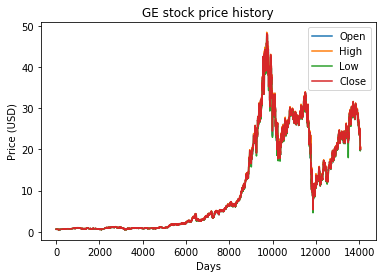

In [5]:
plot_stock(df_ge)

看看最近100天的情况

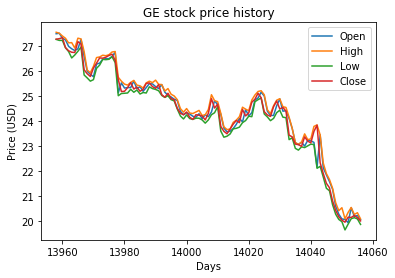

In [6]:
df_ge_latest_100 = df_ge[-100:-1]
plot_stock(df_ge_latest_100)

In [7]:
print("checking if any null values are present\n", df_ge.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


数据预处理

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 只选取了5个列，去掉了日期列
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 11246 2812


## 格式化数据给LSTM
LSTM要求的输入数据的形状为`[batch_size, time_steps, features]`，是三维数组，即每次喂入的数据包含batch_size个样本，每个样本包括time_steps行，每行有features个数据（特性）：
* batch_size：批次大小，决定了一次喂给LSTM的数据多少
* time_steps：LSTM将前面time_steps个时间点的数据参与下一个时间点的预测，在本例中，time_steps=60，即前面两个月的数据参与下一日股价的预测。
* features：输入参数个数

本案例中，TIME_STEPS=60,BATCH_SIZE=2，因此可以想象为摞起来的若干个平面，每个平面是(60,5)，每两个平面组成一个batch喂入LSTM。

在LSTM中，数据要给出两类：
* 训练样本，用来逐步推断计算用的数据。根据TIME_STEPS的设置，训练样本通常比原始的数据要大一些，如下图所示，假设TIME_STEPS=3，使用不同的颜色框出了三个批次的数据。显然，这个图片中的数据可以有7-3=4个批次。注意到，目标样本只关注收盘价。
![LSTM的数据含义](imgs/lstm-time-steps-meaning.png)
* 目标样本，通过训练后的预测值要和目标样本比较。目标样本相当于“标签”

In [9]:
TIME_STEPS=60
BATCH_SIZE=2

In [10]:
from tqdm import tqdm_notebook
def build_timeseries(mat, y_col_index):
    """
    返回值：
    x：训练样本，符合LSTM要求的三维数据
    y：目标样本，本例可以通过y_col_index来选择收盘价、开盘价等作为目标样本
    """
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i] # 第i个训练样本由TIME_STEPS行组成
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [11]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [12]:
x_t, y_t = build_timeseries(x_train, 3) 
x_t = trim_dataset(x_t, BATCH_SIZE) # 训练样本
y_t = trim_dataset(y_t, BATCH_SIZE) # 目标样本
x_temp, y_temp = build_timeseries(x_test, 3)
# 将剩余的数据均分为测试数据和验证数据
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (11186, 60, 5) (11186,)



length of time-series i/o (2752, 60, 5) (2752,)


创建模型

In [13]:
learning_rate = 0.001
EPOCHS = 5

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, # 100个LSTM单元
        batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), # 这个参数不需要了？       
        stateful=True, kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(20,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (2, 32)                   4864      
_________________________________________________________________
dropout_2 (Dropout)          (2, 32)                   0         
_________________________________________________________________
dense_4 (Dense)              (2, 20)                   660       
_________________________________________________________________
dense_5 (Dense)              (2, 1)                    21        
Total params: 5,545
Trainable params: 5,545
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x_t, y_t, epochs=EPOCHS, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))

Train on 11186 samples, validate on 1376 samples
Epoch 1/5
 - 284s - loss: 0.0084 - val_loss: 0.0486
Epoch 2/5
 - 294s - loss: 0.0030 - val_loss: 0.0412
Epoch 3/5
 - 291s - loss: 0.0032 - val_loss: 0.0362
Epoch 4/5
 - 270s - loss: 0.0033 - val_loss: 0.0315
Epoch 5/5
 - 273s - loss: 0.0032 - val_loss: 0.0304


In [22]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0068302232985359285 (1376,) (1376,)
[0.5097003  0.51370203 0.5152754  0.5151894  0.51374406 0.5101851
 0.5063903  0.5081391  0.50179064 0.4887984  0.48371333 0.4890606
 0.49402717 0.49904144 0.49942178]
[0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362 0.32947426 0.32783551 0.33443256
 0.33249967 0.3386135  0.34352978]


In [24]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[24.719215 24.909687 24.984575 24.980482 24.911686 24.742292 24.561668
 24.644907 24.342741 23.72435  23.482315 23.73683  23.973223 24.211887
 24.22999 ]
[16.139 16.264 16.004 16.046 15.581 15.258 15.337 15.87  15.972 16.141
 16.063 16.377 16.285 16.576 16.81 ]


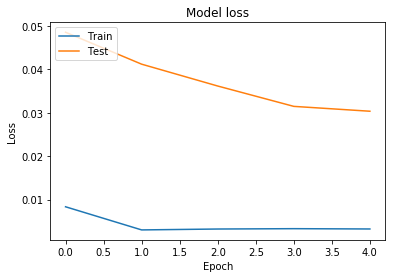

In [25]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

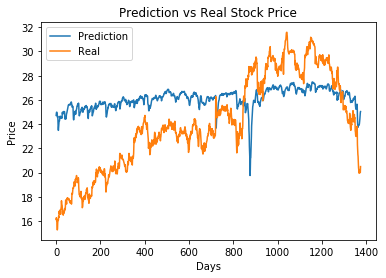

In [26]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)